In [8]:
!pip install nltk


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [9]:
import pandas as pd
import re
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


In [10]:
df = pd.read_csv('data.csv')


In [11]:
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
StopWords = set(stopwords.words('english'))


In [17]:
df['Tweet'] = df['Tweet'].apply(lambda x: x.lower())#lowercase

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'(@[\w]+\s)+','username ',x))#username

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'http\S+|www\S+','http',x))#link

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'#(([\w]+\s[\w]+)+)',r'\1',x))#hashtags

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'(#[\w]+)+',' ',x))#hashtags

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub('[^\w\s]','',x))#punctuation and all emojis

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub('amp','and',x))

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub('\s+',' ',x))#remove whitespaces

df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))#lemmatization

df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in StopWords]))


In [18]:
df['category'] = df['Label'].apply(lambda x: 1 if x =='Joyous' else 2 if x =='Sarcasm' else 0)

In [20]:
df.head()

,Label,Tweet,category
0,Schadenfreude,username police officer question think wa america,0
1,Schadenfreude,username please report carwash bitch screaming...,0
2,Sarcasm,username right wing christianity mean ignorant...,2
3,Schadenfreude,username part history wont whats point getting...,0
4,Sarcasm,username guess forecast wa wrong least previou...,2


In [21]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


In [22]:
X, y = df['Tweet'], df['Label']
metrics = []

skf = KFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    vect = TfidfVectorizer(ngram_range=(1,3), max_features=1500)
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    svm = SVC()
    svm.fit(X_train_dtm, y_train)
    y_pred_class = svm.predict(X_test_dtm)

    metrics.append(accuracy_score(y_test, y_pred_class))

metrics = np.array(metrics)
print('Mean accuracy: ', np.mean(metrics, axis=0))
print('Std for accuracy: ', np.std(metrics, axis=0))
print(classification_report(y_test, y_pred_class))

Mean accuracy:  0.7163844446312433
Std for accuracy:  0.007810575136913502
               precision    recall  f1-score   support

       Joyous       0.60      0.95      0.73       280
      Sarcasm       0.77      0.31      0.44       216
Schadenfreude       0.85      0.75      0.80       305

     accuracy                           0.70       801
    macro avg       0.74      0.67      0.66       801
 weighted avg       0.74      0.70      0.68       801



In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

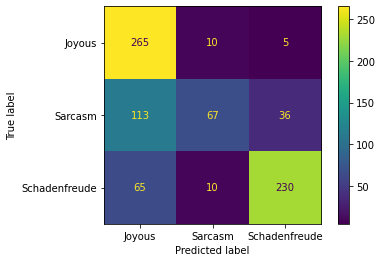

In [24]:
cm = confusion_matrix(y_test, y_pred_class, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()